# Experiment 7: Sequence-to-Sequence Learning with Transformers
## English to Spanish Machine Translation

This notebook implements a complete Transformer-based Encoder-Decoder model for English-to-Spanish translation using PyTorch.

## Step 1: Mount Google Drive and Load Dataset

In [7]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the path to your uploaded spa.txt file
# Update this path to match where you uploaded the file in your Drive
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/spa.txt'

# Verify file exists
import os
if os.path.exists(DATASET_PATH):
    print(f"Dataset found at: {DATASET_PATH}")
    with open(DATASET_PATH, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    print(f"Total sentence pairs: {len(lines)}")
    print("Sample lines:")
    for line in lines[:5]:
        print(repr(line))
else:
    print(f"File not found at {DATASET_PATH}. Please update the path.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset found at: /content/drive/MyDrive/Colab Notebooks/Deep Learning/spa.txt
Total sentence pairs: 118964
Sample lines:
'Go.\tVe.\n'
'Go.\tVete.\n'
'Go.\tVaya.\n'
'Go.\tVáyase.\n'
'Hi.\tHola.\n'


## Step 2: Install Dependencies

In [8]:
!pip install sacrebleu -q
print("Dependencies installed.")

Dependencies installed.


## Step 3: Imports

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import math
import time
import random
import re
from collections import Counter
import sacrebleu
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Step 4: Data Preprocessing

In [10]:
# Special tokens
PAD_TOKEN = '<pad>'
SOS_TOKEN = '<sos>'
EOS_TOKEN = '<eos>'
UNK_TOKEN = '<unk>'

def tokenize(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([.!?¿¡,;:])", r" \1", sentence)
    sentence = re.sub(r"[^a-záéíóúüñ¿¡.!?,;:' ]", " ", sentence)
    tokens = sentence.split()
    return tokens

def load_data(filepath, num_samples=50000):
    pairs = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                eng = parts[0].strip()
                spa = parts[1].strip()
                if eng and spa:
                    pairs.append((eng, spa))

    # Sample a subset
    random.shuffle(pairs)
    pairs = pairs[:num_samples]
    print(f"Loaded {len(pairs)} sentence pairs (sampled from full dataset).")
    return pairs

class Vocabulary:
    def __init__(self):
        self.word2idx = {PAD_TOKEN: 0, SOS_TOKEN: 1, EOS_TOKEN: 2, UNK_TOKEN: 3}
        self.idx2word = {0: PAD_TOKEN, 1: SOS_TOKEN, 2: EOS_TOKEN, 3: UNK_TOKEN}
        self.word_count = Counter()

    def build(self, sentences, min_freq=2):
        for sentence in sentences:
            self.word_count.update(tokenize(sentence))
        for word, count in self.word_count.items():
            if count >= min_freq and word not in self.word2idx:
                idx = len(self.word2idx)
                self.word2idx[word] = idx
                self.idx2word[idx] = word
        print(f"Vocabulary size: {len(self.word2idx)}")

    def encode(self, sentence):
        tokens = tokenize(sentence)
        return [self.word2idx.get(t, self.word2idx[UNK_TOKEN]) for t in tokens]

    def decode(self, indices):
        words = []
        for idx in indices:
            word = self.idx2word.get(idx, UNK_TOKEN)
            if word in (EOS_TOKEN, PAD_TOKEN):
                break
            if word != SOS_TOKEN:
                words.append(word)
        return ' '.join(words)

# Load data
pairs = load_data(DATASET_PATH, num_samples=50000)

# Build vocabularies
eng_sentences = [p[0] for p in pairs]
spa_sentences = [p[1] for p in pairs]

print("Building English vocabulary...")
eng_vocab = Vocabulary()
eng_vocab.build(eng_sentences, min_freq=2)

print("Building Spanish vocabulary...")
spa_vocab = Vocabulary()
spa_vocab.build(spa_sentences, min_freq=2)

# Split data: 80% train, 10% val, 10% test
n = len(pairs)
n_train = int(0.8 * n)
n_val = int(0.1 * n)

train_pairs = pairs[:n_train]
val_pairs   = pairs[n_train:n_train + n_val]
test_pairs  = pairs[n_train + n_val:]

print(f"\nData split: Train={len(train_pairs)}, Val={len(val_pairs)}, Test={len(test_pairs)}")

Loaded 50000 sentence pairs (sampled from full dataset).
Building English vocabulary...
Vocabulary size: 6138
Building Spanish vocabulary...
Vocabulary size: 9708

Data split: Train=40000, Val=5000, Test=5000


## Step 5: Dataset and DataLoader

In [11]:
MAX_LEN = 50  # Max sentence length

class TranslationDataset(Dataset):
    def __init__(self, pairs, src_vocab, tgt_vocab, max_len=MAX_LEN):
        self.pairs = pairs
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src_sentence, tgt_sentence = self.pairs[idx]

        src_ids = self.src_vocab.encode(src_sentence)
        tgt_ids = self.tgt_vocab.encode(tgt_sentence)

        # Truncate
        src_ids = src_ids[:self.max_len]
        tgt_ids = tgt_ids[:self.max_len]

        # Add SOS/EOS to target
        tgt_ids = [self.tgt_vocab.word2idx[SOS_TOKEN]] + tgt_ids + [self.tgt_vocab.word2idx[EOS_TOKEN]]

        return src_ids, tgt_ids

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)

    src_lens = [len(s) for s in src_batch]
    tgt_lens = [len(t) for t in tgt_batch]

    max_src = max(src_lens)
    max_tgt = max(tgt_lens)

    padded_src = [s + [0] * (max_src - len(s)) for s in src_batch]
    padded_tgt = [t + [0] * (max_tgt - len(t)) for t in tgt_batch]

    return torch.tensor(padded_src, dtype=torch.long), torch.tensor(padded_tgt, dtype=torch.long)

BATCH_SIZE = 64

train_dataset = TranslationDataset(train_pairs, eng_vocab, spa_vocab)
val_dataset   = TranslationDataset(val_pairs,   eng_vocab, spa_vocab)
test_dataset  = TranslationDataset(test_pairs,  eng_vocab, spa_vocab)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

Train batches: 625, Val batches: 79, Test batches: 79


## Step 6: Transformer Model Components

In [12]:
# ─────────────────────────────────────────────────────────────
# 6.1  Positional Encoding
# ─────────────────────────────────────────────────────────────
class PositionalEncoding(nn.Module):
    """
    Sinusoidal positional encoding.
    PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    """
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)             # [max_len, d_model]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)   # [max_len, 1]
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )                                               # [d_model/2]

        pe[:, 0::2] = torch.sin(position * div_term)   # even dims
        pe[:, 1::2] = torch.cos(position * div_term)   # odd  dims

        pe = pe.unsqueeze(0)                            # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


# ─────────────────────────────────────────────────────────────
# 6.2  Scaled Dot-Product Attention
# ─────────────────────────────────────────────────────────────
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Q, K, V: [batch, heads, seq_len, d_k]
    Returns: context [batch, heads, seq_len, d_k], attn_weights
    """
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)  # [B, H, T_q, T_k]

    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))

    attn_weights = F.softmax(scores, dim=-1)
    attn_weights = torch.nan_to_num(attn_weights, nan=0.0)  # handle all-inf rows

    context = torch.matmul(attn_weights, V)  # [B, H, T_q, d_k]
    return context, attn_weights


# ─────────────────────────────────────────────────────────────
# 6.3  Multi-Head Attention
# ─────────────────────────────────────────────────────────────
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model   = d_model
        self.num_heads = num_heads
        self.d_k       = d_model // num_heads

        self.W_Q = nn.Linear(d_model, d_model, bias=False)
        self.W_K = nn.Linear(d_model, d_model, bias=False)
        self.W_V = nn.Linear(d_model, d_model, bias=False)
        self.W_O = nn.Linear(d_model, d_model, bias=False)

    def split_heads(self, x):
        """[B, T, d_model] → [B, H, T, d_k]"""
        B, T, _ = x.size()
        return x.view(B, T, self.num_heads, self.d_k).transpose(1, 2)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_Q(Q))  # [B, H, T_q, d_k]
        K = self.split_heads(self.W_K(K))
        V = self.split_heads(self.W_V(V))

        context, _ = scaled_dot_product_attention(Q, K, V, mask)

        B, H, T, d_k = context.size()
        context = context.transpose(1, 2).contiguous().view(B, T, self.d_model)  # [B, T, d_model]
        return self.W_O(context)


# ─────────────────────────────────────────────────────────────
# 6.4  Position-wise Feed-Forward Network
# ─────────────────────────────────────────────────────────────
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x):
        return self.net(x)


# ─────────────────────────────────────────────────────────────
# 6.5  Encoder Layer
# ─────────────────────────────────────────────────────────────
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn  = MultiHeadAttention(d_model, num_heads)
        self.ffn        = FeedForward(d_model, d_ff, dropout)
        self.norm1      = nn.LayerNorm(d_model)
        self.norm2      = nn.LayerNorm(d_model)
        self.dropout    = nn.Dropout(dropout)

    def forward(self, x, src_mask):
        # Self-attention + residual
        attn_out = self.self_attn(x, x, x, src_mask)
        x = self.norm1(x + self.dropout(attn_out))
        # FFN + residual
        ffn_out = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_out))
        return x


# ─────────────────────────────────────────────────────────────
# 6.6  Decoder Layer
# ─────────────────────────────────────────────────────────────
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn   = MultiHeadAttention(d_model, num_heads)  # masked
        self.cross_attn  = MultiHeadAttention(d_model, num_heads)  # encoder-decoder
        self.ffn         = FeedForward(d_model, d_ff, dropout)
        self.norm1       = nn.LayerNorm(d_model)
        self.norm2       = nn.LayerNorm(d_model)
        self.norm3       = nn.LayerNorm(d_model)
        self.dropout     = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        # Masked self-attention
        attn1 = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn1))
        # Cross-attention (queries from decoder, keys/values from encoder)
        attn2 = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn2))
        # FFN
        ffn_out = self.ffn(x)
        x = self.norm3(x + self.dropout(ffn_out))
        return x


# ─────────────────────────────────────────────────────────────
# 6.7  Full Transformer
# ─────────────────────────────────────────────────────────────
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size,
                 d_model=256, num_heads=8, num_layers=3,
                 d_ff=512, dropout=0.1, max_len=MAX_LEN + 2):
        super().__init__()

        # Embeddings
        self.src_embedding = nn.Embedding(src_vocab_size, d_model, padding_idx=0)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model, padding_idx=0)

        # Positional encoding
        self.pos_enc = PositionalEncoding(d_model, dropout, max_len)

        # Encoder / Decoder stacks
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        # Output projection
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.d_model = d_model

        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def make_src_mask(self, src):
        #Mask padding tokens in source. [B, 1, 1, T_src]
        return (src != 0).unsqueeze(1).unsqueeze(2)

    def make_tgt_mask(self, tgt):
        #Combine padding mask + causal mask. [B, 1, T_tgt, T_tgt]
        B, T = tgt.size()
        pad_mask  = (tgt != 0).unsqueeze(1).unsqueeze(2)         # [B, 1, 1, T]
        causal_mask = torch.tril(torch.ones(T, T, device=tgt.device)).bool()  # [T, T]
        return pad_mask & causal_mask.unsqueeze(0).unsqueeze(0)   # [B, 1, T, T]

    def encode(self, src):
        src_mask = self.make_src_mask(src)
        x = self.pos_enc(self.src_embedding(src) * math.sqrt(self.d_model))
        for layer in self.encoder_layers:
            x = layer(x, src_mask)
        return x, src_mask

    def decode(self, tgt, enc_output, src_mask):
        tgt_mask = self.make_tgt_mask(tgt)
        x = self.pos_enc(self.tgt_embedding(tgt) * math.sqrt(self.d_model))
        for layer in self.decoder_layers:
            x = layer(x, enc_output, src_mask, tgt_mask)
        return self.fc_out(x)  # [B, T_tgt, tgt_vocab_size]

    def forward(self, src, tgt):
        enc_output, src_mask = self.encode(src)
        return self.decode(tgt, enc_output, src_mask)

print("Model classes defined successfully.")

Model classes defined successfully.


## Step 7: Initialize Model, Loss, and Optimizer

In [13]:
# Hyperparameters
D_MODEL   = 256
NUM_HEADS = 8
NUM_LAYERS = 3
D_FF      = 512
DROPOUT   = 0.1
LEARNING_RATE = 1e-3
NUM_EPOCHS    = 20

model = Transformer(
    src_vocab_size = len(eng_vocab.word2idx),
    tgt_vocab_size = len(spa_vocab.word2idx),
    d_model   = D_MODEL,
    num_heads = NUM_HEADS,
    num_layers = NUM_LAYERS,
    d_ff      = D_FF,
    dropout   = DROPOUT,
    max_len   = MAX_LEN + 10
).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

# Loss: ignore PAD tokens (index 0)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9)

# LR Scheduler (reduce on plateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

print(f"Optimizer: Adam | LR: {LEARNING_RATE}")

Total trainable parameters: 10,495,980
Optimizer: Adam | LR: 0.001


## Step 8: Training and Evaluation Functions

In [14]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for src, tgt in loader:
        src = src.to(device)
        tgt = tgt.to(device)

        # Teacher forcing: feed tgt[:-1] as input, predict tgt[1:]
        tgt_input  = tgt[:, :-1]   # [B, T-1] – input to decoder
        tgt_output = tgt[:, 1:]    # [B, T-1] – expected output

        optimizer.zero_grad()

        logits = model(src, tgt_input)  # [B, T-1, vocab_size]

        # Reshape for cross-entropy
        loss = criterion(
            logits.reshape(-1, logits.size(-1)),  # [B*(T-1), vocab]
            tgt_output.reshape(-1)                 # [B*(T-1)]
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in loader:
            src = src.to(device)
            tgt = tgt.to(device)

            tgt_input  = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            logits = model(src, tgt_input)
            loss = criterion(
                logits.reshape(-1, logits.size(-1)),
                tgt_output.reshape(-1)
            )
            total_loss += loss.item()

    return total_loss / len(loader)


def translate_sentence(model, sentence, src_vocab, tgt_vocab, device, max_len=MAX_LEN):
    model.eval()
    src_ids = src_vocab.encode(sentence)
    src_ids = src_ids[:max_len]
    src_tensor = torch.tensor([src_ids], dtype=torch.long).to(device)

    with torch.no_grad():
        enc_output, src_mask = model.encode(src_tensor)

        sos_idx = tgt_vocab.word2idx[SOS_TOKEN]
        eos_idx = tgt_vocab.word2idx[EOS_TOKEN]

        tgt_ids = [sos_idx]
        for _ in range(max_len):
            tgt_tensor = torch.tensor([tgt_ids], dtype=torch.long).to(device)
            logits = model.decode(tgt_tensor, enc_output, src_mask)  # [1, T, vocab]
            next_token = logits[:, -1, :].argmax(dim=-1).item()
            tgt_ids.append(next_token)
            if next_token == eos_idx:
                break

    return tgt_vocab.decode(tgt_ids)


def compute_bleu(model, pairs, src_vocab, tgt_vocab, device, num_samples=500):
    hypotheses = []
    references = []

    sample = random.sample(pairs, min(num_samples, len(pairs)))

    for src_sent, tgt_sent in sample:
        pred = translate_sentence(model, src_sent, src_vocab, tgt_vocab, device)
        hypotheses.append(pred)
        references.append(tgt_sent.lower().strip())

    result = sacrebleu.corpus_bleu(hypotheses, [references])
    return result.score

print("Training functions defined.")

Training functions defined.


## Step 9: Train the Model

In [15]:
train_losses = []
val_losses   = []
best_val_loss = float('inf')

print("Starting training...")
print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Val Loss':>10} | {'Time (s)':>10}")
print("-" * 45)

total_start = time.time()

for epoch in range(1, NUM_EPOCHS + 1):
    start = time.time()

    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss   = evaluate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    elapsed = time.time() - start
    print(f"{epoch:>5} | {train_loss:>10.4f} | {val_loss:>10.4f} | {elapsed:>10.1f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_transformer.pt')

total_time = time.time() - total_start
print(f"\nTotal training time: {total_time:.1f}s ({total_time/60:.1f} minutes)")

Starting training...
Epoch | Train Loss |   Val Loss |   Time (s)
---------------------------------------------
    1 |     5.4459 |     5.9253 |       26.6
    2 |     4.8253 |     4.6084 |       20.7
    3 |     4.4369 |     4.5013 |       19.5
    4 |     4.2440 |     4.3515 |       21.7
    5 |     4.0805 |     4.2523 |       19.9
    6 |     3.9559 |     4.2227 |       20.9
    7 |     3.8725 |     4.1968 |       19.2
    8 |     3.8090 |     4.2623 |       20.9
    9 |     3.7585 |     4.1803 |       19.9
   10 |     3.7168 |     4.1694 |       20.7
   11 |     3.6768 |     4.2126 |       19.6
   12 |     3.6453 |     4.2304 |       20.6
   13 |     3.6126 |     4.2217 |       20.2
   14 |     3.4909 |     4.2280 |       20.5
   15 |     3.4542 |     4.1908 |       20.2
   16 |     3.4359 |     4.3192 |       20.1
   17 |     3.3581 |     4.2112 |       20.6
   18 |     3.3370 |     4.2992 |       20.0
   19 |     3.3248 |     4.2230 |       20.2
   20 |     3.2810 |     4.2378 |

## Step 10: Plot Training Curves

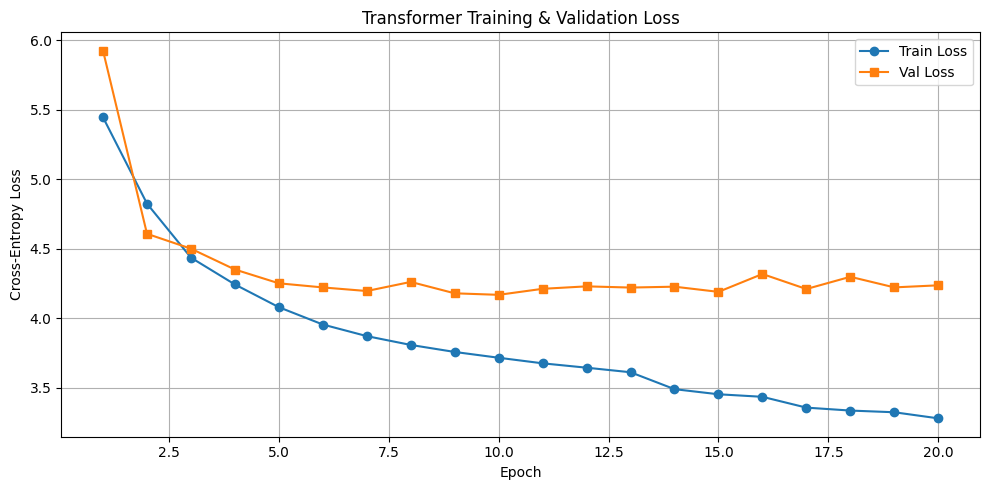

Loss curve saved.


In [16]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses,   label='Val Loss',   marker='s')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Transformer Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_curve.png', dpi=150)
plt.show()
print("Loss curve saved.")

## Step 11: BLEU Score Evaluation

In [17]:
# Load best model checkpoint
model.load_state_dict(torch.load('best_transformer.pt', map_location=device))
print("Best model loaded.")

print("\nComputing BLEU scores (this may take a minute)...")
val_bleu  = compute_bleu(model, val_pairs,  eng_vocab, spa_vocab, device, num_samples=300)
test_bleu = compute_bleu(model, test_pairs, eng_vocab, spa_vocab, device, num_samples=500)

print(f"\n{'='*40}")
print(f"  Validation BLEU Score : {val_bleu:.2f}")
print(f"  Test       BLEU Score : {test_bleu:.2f}")
print(f"{'='*40}")

Best model loaded.

Computing BLEU scores (this may take a minute)...



  Validation BLEU Score : 0.99
  Test       BLEU Score : 0.89


## Step 12: Sample Translations

In [18]:
print("Sample Translations from Test Set")
print("=" * 65)

samples = random.sample(test_pairs, 10)
for eng, expected_spa in samples:
    predicted = translate_sentence(model, eng, eng_vocab, spa_vocab, device)
    print(f"English  : {eng}")
    print(f"Expected : {expected_spa}")
    print(f"Predicted: {predicted}")
    print("-" * 65)

Sample Translations from Test Set
English  : She fell asleep in my arms.
Expected : Ella se durmió en mis brazos.
Predicted: ella se casó .
-----------------------------------------------------------------
English  : She caught him cheating on a test.
Expected : Lo pilló haciendo trampa en una prueba.
Predicted: ella es <unk> .
-----------------------------------------------------------------
English  : Slavery was legal in the new Republic of Texas.
Expected : La esclavitud era legal en la nueva República de Texas.
Predicted: el <unk> .
-----------------------------------------------------------------
English  : Ask me tomorrow.
Expected : Pregúntame mañana.
Predicted: tienes que ir .
-----------------------------------------------------------------
English  : I was waiting for you.
Expected : Les esperaba.
Predicted: me gusta la <unk> .
-----------------------------------------------------------------
English  : Tom may use my bicycle whenever he wants.
Expected : Tom puede usar mi b

## Step 13: Custom Translation

In [19]:
# Try translating custom English sentences
custom_sentences = [
    "Hello, how are you?",
    "I love learning languages.",
    "The weather is beautiful today.",
    "Where is the train station?",
    "Thank you very much."
]

print("Custom Translations")
print("=" * 65)
for sentence in custom_sentences:
    translation = translate_sentence(model, sentence, eng_vocab, spa_vocab, device)
    print(f"English  : {sentence}")
    print(f"Spanish  : {translation}")
    print("-" * 65)

Custom Translations
English  : Hello, how are you?
Spanish  : ¿has visto ?
-----------------------------------------------------------------
English  : I love learning languages.
Spanish  : me gusta la <unk> .
-----------------------------------------------------------------
English  : The weather is beautiful today.
Spanish  : este es mi padre .
-----------------------------------------------------------------
English  : Where is the train station?
Spanish  : ¿dónde está el <unk> ?
-----------------------------------------------------------------
English  : Thank you very much.
Spanish  : tienes que <unk> .
-----------------------------------------------------------------


## Step 14: Performance Summary & Comparison

In [20]:
print("EXPERIMENT 7 — Results Summary")
print("-" * 40)
print(f"Best validation loss : {best_val_loss:.4f}")
print(f"Validation BLEU     : {val_bleu:.2f}")
print(f"Test BLEU           : {test_bleu:.2f}")
print(f"Training time       : {total_time/60:.1f} min")
print(f"Total parameters    : {total_params:,}")

EXPERIMENT 7 — Results Summary
----------------------------------------
Best validation loss : 4.1694
Validation BLEU     : 0.99
Test BLEU           : 0.89
Training time       : 6.9 min
Total parameters    : 10,495,980
